# KI-Campus: Learn2Trust
## Lektion 4: Klassifikation

### 1. Einführung
In dieser Lektion geht es darum, wie Künstliche Intelligenz (KI) in der medizinischen Bildanalyse dazu eingesetzt werden kann, um Klassifikationsentscheidungen zu treffen.

Am Beispiel von Röntgenthoraxdaten (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia), die zur Diagnostik von Pneumonie aquiriert wurden, wird demonstriert, wie ein einfaches Klassifikationsnetzwerk programmiert werden kann. Dieses Klassifikationsnetzwerk soll entscheiden, ob in einem präsentierten Eingabebild eine Pneumonie zu erkennen ist oder nicht.

In den verschiedenen Unterkapiteln wird zunächst der Beispieldatensatz gezeigt und anschließend durch Netzwerkerstellung, -training und -evaluation geführt.

*Importieren von benötigten Paketen und anderen Dateien:*

In [ ]:
# import packages
import os
import sys
import time
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore") 

torch.manual_seed(9999);

Mounted at /content/drive


### 2. Datensatz
Der Datensatz für diese Lektion besteht aus Röntgenaufnahmen des Thorax, die erstellt wurden, um Pneumonie (viral oder bakteriell) zu diagnositizieren. Wenn der Datensatz geladen wurde, werden Beispielbilder visualisiert und optional Label angezeigt, die angeben, ob Experten bei den vorliegenden Aufnahmen eine Pneumonie diagnostiziert haben oder nicht.

Der Datensatz besteht aus insgesamt 5573 Bildern. Davon sind 3990 Röntgenbilder Patienten zuzuordnen, bei denen eine Pneumonie diagnostiziert wurde und 1583 Röntgenbilder Patienten zuzuordnen, bei denen keine Pneumonie diagnostiziert wurde.

*Laden der Bilddaten und den zugehörigen Labeln:*

In [ ]:
# load image and label datasets as tensors
data_img = torch.load('pneumonia_detection_data_img.pth')
data_label = torch.load('pneumonia_detection_data_label.pth')
print(f'shape of data_img: {data_img.shape}')  # shape = (N: number of data, C: channel, H: height, W: width)
print(f'shape of data_label: {data_label.shape}')

shape of data_img: torch.Size([5573, 1, 128, 128])
shape of data_label: torch.Size([5573])


Wenn alle Daten geladen wurden, wird der Datensatz aufgeteilt in 4500 Trainingsbilder, 500 Validierungsbilder und 573 Testbilder.

Die **Trainingsbilder** werden dem Klassifikationsnetzwerk während des Trainings wiederholt präsentiert und dienen dazu, dass das Modell dadurch lernt. Mithilfe der **Validierungsbilder** wird während des Trainingsvorganges validiert, wie gut das Modell mit Eingabedaten umgehen kann, die es nicht zum Lernen verwendet hat. Anhand der **Testbilder** wird nach abgeschlossenem Training evaluiert, wie gut das Modell Daten klassifizieren kann, die während des Trainings weder als Trainings- noch als Validierungsdaten gedient haben.

*Aufteilung der Daten in Trainings-, Validierungs- und Testdatensatz:*

In [ ]:
'''
TODO: SPLIT THE DATASET
1. Create a random permutation of integer values from 0 to 5572, associated with image indices.
2. Split this permutation into 'idx_train', 'idx_val' and 'idx_test'. Use a 
split of 4500/500/573 and make sure no indices occur in multiple datasets.

Hint:
- Use torch.randperm(), see documentation on https://pytorch.org/docs/stable/generated/torch.randperm.html
- Use list slicing as describes on https://railsware.com/blog/python-for-machine-learning-indexing-and-slicing-for-lists-tuples-strings-and-other-sequential-types/
'''
# idx_list = 

# idx_train = 
# idx_val = 
# idx_test = 

In [ ]:
# ratio between 'Pneumonia'/'Keine Pneumonie' in training, validation and test data
print(torch.sum(data_label[idx_train])/abs(torch.sum(data_label[idx_train]-1)))
print(torch.sum(data_label[idx_val])/abs(torch.sum(data_label[idx_val]-1)))
print(torch.sum(data_label[idx_test])/abs(torch.sum(data_label[idx_test]-1)))

tensor(2.4938)
tensor(2.6232)
tensor(2.6497)


*Darstellung eines zufällig ausgewählten Beispielbildes aus dem Datensatz:*

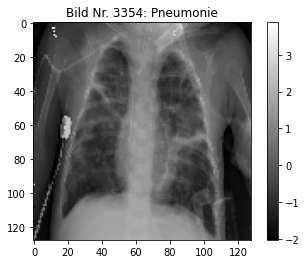

In [ ]:
# visualize example images with expert labels
idx = np.random.randint(0, 5572)
plt.imshow(data_img[idx,0,:,:], cmap='gray')
plt.colorbar()
if int(data_label[idx]) == 1:
    title = f"Bild Nr. {idx}: Pneumonie"
else:
    title = f"Bild Nr. {idx}: Keine Pneumonie"
plt.title(title)
plt.show()

### 4. Netzwerkarchitektur
Das Modell, das in dieser Lektion zur Klassifikation von Röntgenthoraxbildern verwendet werden soll, ist ein Faltungsnetzwerk bestehend aus vier Blöcken mit Faltungen, Batch-Normalisierungen und Aktivierungen, gefolgt von einem Modul aus voll-verbundenen Schichten.

In diesem Unterkapitel werden die einzelnen Bausteine des Klassifikationsnetzwerkes beschrieben und ein Einblick in deren Programmierung gegeben.

#### Bausteine
##### *1. Faltungsblöcke*
Die insgesamt vier Faltungsblöcke bestehen jeweils aus zweimal der Abfolge einer zweidimensionalen Faltung, gefolgt von einer Batch-Normalisierung und einer Aktivierung. Auf jeden der Faltungsblöcke folgt ein Max-Pooling. In jedem Faltungsblock erhöht sich die Anzahl der Merkmalskanäle, während jede Pooling-Operation die räumliche Auflösung reduziert.

```
# Code für einen Faltungsblock
conv_block = nn.Sequential(nn.Conv2d(n_ch_in, n_ch_out, kernel_size),
                           nn.BatchNorm2d(n_ch_out),
                           nn.ReLU(),

                           nn.Conv2d(n_ch_out, n_ch_out, kernel_size),
                           nn.BatchNorm2d(n_ch_out),
                           nn.ReLU()
                          )
```
##### *2. Modul aus voll-verbundenen Schichten*
Das Klassifikationsmodell wird durch ein Modul bestehend aus voll-verbundenen Schichten abgeschlossen. Dabei wechseln sich lineare Transformationen mit Aktivierungsfunktionen ab. Die Ausgabe der letzten Schicht besitzt zwei Merkmalskanäle - entsprechend der Anzahl der Klassen (Pneumonie/keine Pneumonie).

```
# Code für das Modul aus voll-verbundenen Schichten
fc_block = nn.Sequential(nn.Linear(n_in, n_out_tmp),
                         nn.ReLU(),

                         nn.Linear(n_out_tmp, n_out),
                         nn.ReLU(),

                         nn.Linear(n_out_tmp, n_classes)
                        )
```

*Definition des Modells "classificationCNN":

In [ ]:
# classification model
class classificationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        TODO: BUILD THE CNN
        1. Build four convolution blocks by simply copying the given code in the description above.
        2. Set the number of feature channels by assinging integer values to 'n_ch_in' and 'n_ch_out'.
             Since our data consists of one-dimensional greyscale images, the 'n_ch_in'
             of the first block is 1. 
             The choice of parameters is theoretically up to you, but it is recommended
             to bring the 'n_ch_out' up 10 in the first conv_block.
             Then double the number of feature channel within every next conv_block
             by assigning 'n_ch_in' the value of the previous 'n_ch_out'
             and assigning 'n_ch_out' the double value of 'n_ch_in'.
        3. Set the kernel sizes to 3.
        '''
        # self.conv_block0 = 

        # self.conv_block1 = 

        # self.conv_block2 = 

        # self.conv_block3 = 

        self.fc_block = nn.Sequential(
            nn.Linear(4*4*80, 120),
            nn.ReLU(),
            nn.Linear(120, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

        self.maxPool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.maxPool(self.conv_block0(x))
        x = self.maxPool(self.conv_block1(x))
        x = self.maxPool(self.conv_block2(x))
        x = self.maxPool(self.conv_block3(x))
        x = torch.flatten(x,1)
        x = self.fc_block(x)
        return x

### 5. Training
Während des Trainingsprozesses werden dem im vorherigen Unterkapitel Netzwerkarchitektur beschriebenen Modell **Trainingsbilder** mit bekannten **Grundwahrheiten** übergeben. Das **Modell** trifft zu jedem Eingabebild eine **Vorhersage**, die dann über die **Lossfunktion** mit der Grundwahrheit verglichen wird. Basierend auf der Ausgabe der Lossfunktion werden durch die **Backpropagation** die **Parameter** des Modells angepasst. Dieser Prozess wird so lange wiederholt, bis die Parameter des Modells so weit angepasst sind, dass sie bei der Backpropagation nicht mehr geändert werden müssen.



*Definition der Lossfunktion und einzelner Trainingsparameter, wie zum Beispiel der Anzahl an Trainingsepochen oder der Batch-Größe:*

In [ ]:
# set up loss function
class_weight = torch.sqrt(1.0/(torch.bincount(data_label[idx_train].view(-1)).float()))
class_weight = class_weight/class_weight.mean()
class_weight = class_weight
loss_function = nn.CrossEntropyLoss(weight=class_weight)

# set parameters for batch size and number of epochs
batch_size = 25
batch_size_val = 25
n_epochs = 26
every_epoch = 5

*Trainingsschleife:*

In [ ]:
# build models
model = classificationCNN()
bestNet = classificationCNN()

# set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=(9*n_epochs)//10, gamma=0.1)

losses_training = []
losses_validation = []

best_loss = np.infty

t0 = time.time()

# training loop with validation phase
for epoch in range(n_epochs): 
    
    ########################################
    #               TRAINING               #
    ########################################
    
    sum_loss = 0
    
    # create batch of randomly shuffled training images
    train_batches = torch.randperm(len(idx_train))[:len(idx_train)-len(idx_train)%batch_size].view(-1,batch_size)
    
    # parameters must be trainable
    model.train()
    with torch.set_grad_enabled(True):
        
        # main loop to process all training samples (packed into batches)
        for batch_idx in train_batches:
            '''
            TODO: PERFORM THE FORWARD PASS AND CALCULATE LOSS
            1. Load the input data by taking the current 'batch_idx' of 'data_img'.
            2. Do the same for the label by taking the current 'batch_idx' of 'data_label'.
            3. Pass the input data forward through the model by giving the previously 
                loaded input data to the 'model()' as an argument. The return value
                is the models 'prediction'.
            4. Calculate the loss by passing the 'prediction' as first argument and
                'label' as second argument to the 'loss_function'.
            Hint: Streamlit version...
            '''
            # input = 

            # label = 

            # prediction = 

            # loss = 
            
            # backpropagation step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
      
        losses_training.append(sum_loss/ len(train_batches))

    ########################################
    #              VALIDATION              #
    ########################################
  
    sum_loss = 0
     
    # parameters must not be trainable
    model.eval()
    with torch.set_grad_enabled(False):
        
        val_batches = torch.randperm(len(idx_val))[:len(idx_val)-len(idx_val)%batch_size_val].view(-1,batch_size_val)

        # main loop to process all validation samples (packed into batches)
        for batch_idx in val_batches:
            '''
            TODO: PERFORM THE FORWARD PASS
            1. Load the input data by taking the current 'batch_idx' of 'data_img'.
            2. Do the same for the label by taking the current 'batch_idx' of 'data_label'.
            3. Pass the input data forward through the model by giving the previously 
                loaded input data to the 'model()' as an argument. The return value
                is the models 'prediction'.
            4. Calculate the loss by passing the 'prediction' as first argument and
                'label' as second argument to the 'loss_function'.
            '''
            # input = 

            # label = 

            # prediction = 

            # loss = 
            
            # no need to backpropagate here
            sum_loss += loss.item() / len(val_batches)
      
        validation_loss = sum_loss
        losses_validation.append(validation_loss)
        
        if validation_loss < best_loss:
            best_loss = validation_loss
            best_state_dict = bestNet.state_dict()
            state_dict = model.state_dict()           
            for name, param in state_dict.items():
                best_state_dict[name].copy_(param)
      
    # scheduler will adapt the learning rate once the step count reaches threshold
    scheduler.step()  
    
    if epoch % every_epoch == 0:
        t1 = time.time()
        print("{:.2f}".format(t1-t0), 's --- Epoch ' + str(epoch) +': Training loss ' + str(losses_training[-1]) + ', Validation loss ' + str(losses_validation[-1]))
        
print('Finished Training')
print('Best validation loss: ' + str(best_loss))

*Darstellung der Loss-Kurve:*

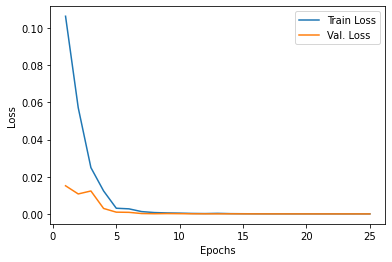

In [ ]:
# visualize training and validation loss over number of epochs
plt.figure()
plt.plot(np.arange(len(losses_training))[1:], losses_training[1:])
plt.plot(np.arange(len(losses_training))[1:], losses_validation[1:])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(('Train Loss', 'Val. Loss'));

### 6. Evaluation
Im vorherigen Unterkapitel *Training* wurde das Modell `bestNet` abgespeichert, das auf den Validierungsdaten die besten Ergebnisse erzielt hat. Dieses Modell soll jetzt während der sogenannten **Inferenz** auf die Testdaten angewendet werden, um zu evaluieren, wie gut das Modell auf Bildern klassifizieren kann, die ihm während der Trainingsphase noch nicht präsentiert wurden.

Während der Evaluation wird bestimmt, bei wie vielen Fällen in den Testdaten

- korrekterweise eine Pneumonie erkannt wurde (True Positive, **TP** )
- korrekterweise keine Pneumonie erkannt wurde (True Negative, **TN**)
- fälschlicherweise eine Pneumonie erkannt wurde (False Positive, **FP**)
- fälschlicherweise keine Pneumonie erkannt wurde (False Negative, **FN**).

Die **Accuracy** gibt an, welcher Anteil an Bildern insgesamt richtig klassifiziert wurden:

`ACCURACY= (TP+TN) / (TP+TN+FP+FN)`

*Testschleife:*

In [ ]:
# evaluation inference
bestNet.eval()

y_gt = []
y_pred = []

# testing loop
for ind in idx_test:

    ########################################
    #                 TEST                 #
    ########################################

    classifications = []

    # load test images and ground truth label
    source_image = data_img[ind].unsqueeze(0)
    target_label = data_label[ind]

    # apply model
    classification = bestNet(source_image).argmax(1)

    y_gt.append(target_label.item())
    y_pred.append(classification.item())
        
# calculate TP, TN, FP, FN and accuracy
tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
print('Scores on test dataset:')
print('TP: ', tp, 'TN: ', tn, 'FP: ', fp, 'FN: ', fn)

acc = (tp+tn)/len(idx_test)
print('ACCURACY = ', acc)

Scores on test dataset:
TP:  416 TN:  148 FP:  9 FN:  0
ACCURACY =  0.9842931937172775


### 7. Ergebnisvisualisierung
Hier wird visualisiert, welche Röntgenbilder richtig und welche Röntgenbilder aus dem Testdatensatz falsch klassifiziert wurden.

In der Bildüberschrift wird jeweils angegeben, ob es sich bei dem angezeigten Fall um TP (True Positive), TN (True Negative), FP (False Positive) oder FN (False Negative) handelt.

*Visualisierung von drei falsch positiv und drei richtig positiv Ergebnissen.*

3 der 9 falsch klassifizierten Bilder:


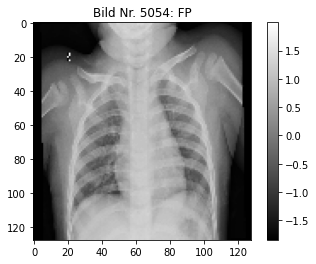

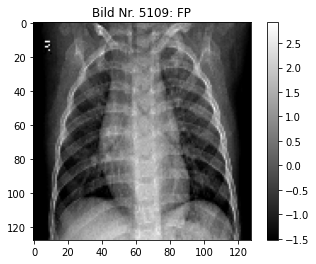

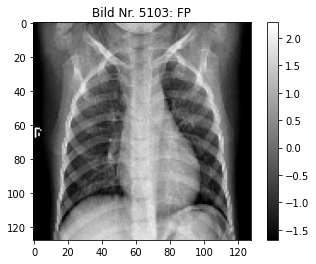

3 der 564 korrekt klassifizierten Bilder:


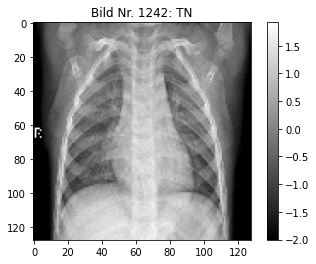

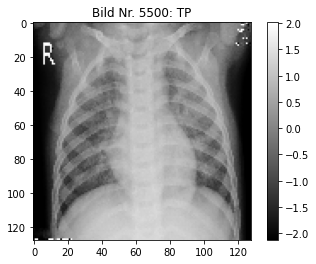

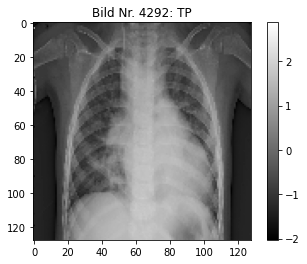

In [ ]:
# visualize correctly and misclassified results
n_imgs = 3

# misclassified images
idx_wrong = torch.cat(torch.where(~torch.eq(torch.tensor(y_gt), torch.tensor(y_pred))))
ii = torch.randperm(len(idx_wrong)).view(-1)
real_idx_wrong = idx_test[idx_wrong[ii[:n_imgs]]]

print(f'{min(n_imgs, len(idx_wrong))} der {len(idx_wrong)} falsch klassifizierten Bilder:')

for i in real_idx_wrong:
    plt.imshow(data_img[i,0,:,:], cmap='gray')
    plt.colorbar()
    if int(data_label[i]) == 1:
        plt.title(f'Bild Nr. {i}: FN')
    else:
        plt.title(f'Bild Nr. {i}: FP')
    plt.show()

# correctly classified images
idx_correct = torch.cat(torch.where(torch.eq(torch.tensor(y_gt), torch.tensor(y_pred))))
ii = torch.randperm(len(idx_correct)).view(-1)
real_idx_correct = idx_test[idx_correct[ii[:n_imgs]]]

print(f'{min(n_imgs, len(idx_correct))} der {len(idx_correct)} korrekt klassifizierten Bilder:')

for j in real_idx_correct:
    plt.imshow(data_img[j,0,:,:], cmap='gray')
    plt.colorbar()
    if int(data_label[j]) == 1:
        plt.title(f'Bild Nr. {j}: TP')
    else:
        plt.title(f'Bild Nr. {j}: TN')
    plt.show()